In [10]:
import os
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

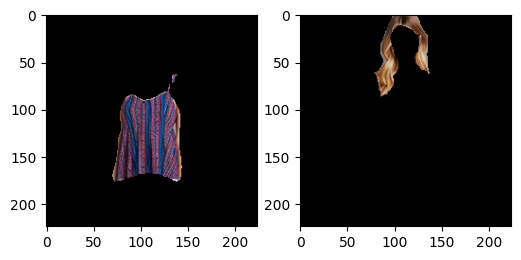

In [11]:
upper_clothes_img_fp = os.path.join("outputs", "segmentation-test", "Upper-clothes-4.png")
hair_clothes_img_fp = os.path.join("outputs", "segmentation-test", "Hair-2.png")

upper_clothes_img_pil = Image.open(upper_clothes_img_fp)
hair_clothes_img_pil = Image.open(hair_clothes_img_fp)

fig, axs = plt.subplots(1,2, figsize=(6,6))
axs[0].imshow(upper_clothes_img_pil)
axs[1].imshow(hair_clothes_img_pil)

[ 63  63  63 ... 176 176 176]
(16616, 2)


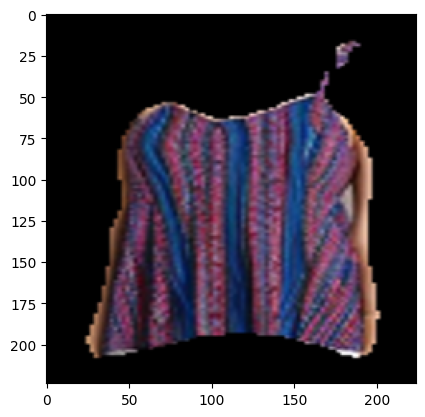

In [27]:
upper_clothes_img_np = np.array(upper_clothes_img_pil)

upper_clothes_indices = np.where(upper_clothes_img_np != 0)
print(upper_clothes_indices[0]) 
# height, width
upper_clothes_indices = np.array([(upper_clothes_indices[0][i], upper_clothes_indices[1][i]) for i in range(len(upper_clothes_indices[0]))])
print(upper_clothes_indices.shape)

y_indices = upper_clothes_indices[:,0]
x_indices = upper_clothes_indices[:,1]

y_min, y_max = min(y_indices) - 10, max(y_indices) + 10
x_min, x_max = min(x_indices) - 10, max(x_indices) + 10

upper_clothes_cropped_np = upper_clothes_img_np[y_min:y_max, x_min:x_max, :]
plt.imshow(upper_clothes_cropped_np)

upper_clothes_cropped_pil = Image.fromarray(upper_clothes_cropped_np)
new_size = (224, 224)
final_upper_clothes_pil = upper_clothes_cropped_pil.resize(new_size)
plt.imshow(final_upper_clothes_pil)

# upper_clothes_masked = upper_clothes_img_np[upper_clothes_mask]

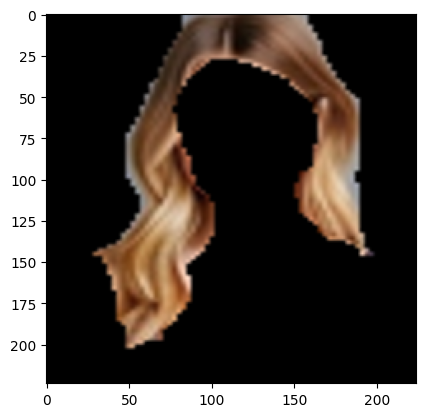

In [43]:
hair_clothes_img_np = np.array(hair_clothes_img_pil)
hair_clothes_indices = np.where(hair_clothes_img_np != 0)

# print(hair_clothes_indices[0]) 

# height, width
hair_clothes_indices = np.array([(hair_clothes_indices[0][i], hair_clothes_indices[1][i]) for i in range(len(hair_clothes_indices[0]))])
# print(hair_clothes_indices.shape)

y_indices = hair_clothes_indices[:,0]
x_indices = hair_clothes_indices[:,1]

org_img_height, org_img_width = hair_clothes_img_np.shape[0], hair_clothes_img_np.shape[1]

y_min, y_max = min(y_indices), max(y_indices)
x_min, x_max = min(x_indices), max(x_indices)

y_min = y_min - 10 if y_min >= 10 else y_min
y_max = y_max + 10 if y_max + 10 < org_img_height else y_max
x_min = x_min - 10 if x_min >= 10 else x_min
x_max = x_max + 10 if x_max + 10 < org_img_width else x_max

hair_clothes_cropped_np = hair_clothes_img_np[y_min:y_max, x_min:x_max, :]
plt.imshow(hair_clothes_cropped_np)

hair_clothes_cropped_pil = Image.fromarray(hair_clothes_cropped_np)
new_size = (224, 224)
final_hair_clothes_pil = hair_clothes_cropped_pil.resize(new_size)
plt.imshow(final_hair_clothes_pil)

# upper_clothes_masked = upper_clothes_img_np[upper_clothes_mask]

In [28]:
import torch
import cv2

In [51]:
def crop_and_resize(img_np,
                    padding: int = 5,
                    new_img_size = (224,224)):

    indices = np.where(img_np != 0)
    indices = np.array([(indices[0][i], indices[1][i]) for i in range(len(indices[0]))])

    y_indices = indices[:,0]
    x_indices = indices[:,1]

    y_min, y_max = min(y_indices), max(y_indices)
    x_min, x_max = min(x_indices), max(x_indices)

    org_img_height, org_img_width = img_np.shape[0], img_np.shape[1]

    y_min = y_min - padding if y_min >= padding else y_min
    y_max = y_max + padding if y_max + padding < org_img_height else y_max
    x_min = x_min - padding if x_min >= padding else x_min
    x_max = x_max + padding if x_max + padding < org_img_width else x_max

    # STEP: Crop
    cropped_img_np = img_np[y_min:y_max, x_min:x_max,:]
    
    # STEP: Resize
    cropped_img_pil = Image.fromarray(cropped_img_np) 
    resized_img_pil = cropped_img_pil.resize(new_img_size)

    return resized_img_pil

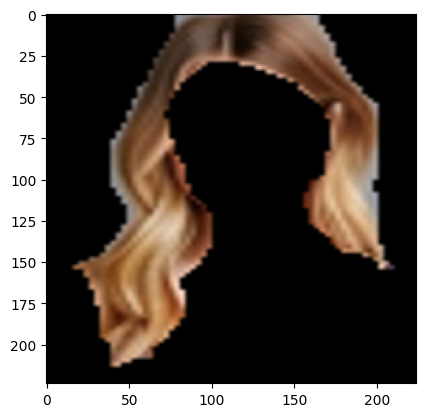

In [52]:
resized_hair = crop_and_resize(np.array(hair_clothes_img_pil))
plt.imshow(resized_hair)

### List all files in the directory

In [1]:
import pandas as pd
import random
import os

# Load the CSV file into a DataFrame
csv_file_path = os.path.join(os.getcwd(), "data", "deepfashion", "deepfashion_multimodal_map_sample.csv")
df = pd.read_csv(csv_file_path)

# Split DataFrame into two based on gender
men_df = df[df['image'].str.startswith('MEN')]
women_df = df[df['image'].str.startswith('WOMEN')]

print(len(men_df))
print(len(women_df))

1506
839


: 

In [2]:
import pandas as pd
import random
import os

# Load the CSV file into a DataFrame
csv_file_path = os.path.join(os.getcwd(), "data", "deepfashion", "deepfashion_multimodal_map_sample.csv")
df = pd.read_csv(csv_file_path)

# Split DataFrame into two based on gender
men_df = df[df['image'].str.startswith('MEN')]
women_df = df[df['image'].str.startswith('WOMEN')]

# Function to generate pairs from a DataFrame
def generate_pairs(df, num_pairs):
    pairs = []
    while len(pairs) < num_pairs:
        # Randomly select two different converted images from the same gender
        image_from = df['image'].sample(n=1).values[0]
        image_to = df['image'].sample(n=1).values[0]

        # Ensure they are different
        while image_from == image_to:
            image_to = df['image'].sample(n=1).values[0]

        # Add the pair to the list
        pairs.append((image_from, image_to))
    return pairs

# Function to split DataFrame into train and test sets
def split_train_test(df, train_ratio=0.9):
    train_size = int(len(df) * train_ratio)
    df_shuffled = df.sample(frac=1).reset_index(drop=True)  # Shuffle the DataFrame
    train_df = df_shuffled.iloc[:train_size]
    test_df = df_shuffled.iloc[train_size:]
    return train_df, test_df

# Split the men and women DataFrames into training and test sets
train_men_df, test_men_df = split_train_test(men_df)
train_women_df, test_women_df = split_train_test(women_df)

# Generate pairs for training and testing
training_samples_men = generate_pairs(train_men_df, 1000)
training_samples_women = generate_pairs(train_women_df, 1000)
test_samples_men = generate_pairs(test_men_df, 50)
test_samples_women = generate_pairs(test_women_df, 50)

# Combine the samples
training_samples = training_samples_men + training_samples_women
test_samples = test_samples_men + test_samples_women

# Shuffle the samples for randomness
random.shuffle(training_samples)
random.shuffle(test_samples)

# Convert to DataFrame for easy saving
training_df = pd.DataFrame(training_samples, columns=['from', 'to'])
test_df = pd.DataFrame(test_samples, columns=['from', 'to'])

# Save the training and test samples to CSV
trg_fp = os.path.join(os.getcwd(), "data", "deepfashion", "pairs-train-all_multimodal_sample.csv")
test_fp = os.path.join(os.getcwd(), "data", "deepfashion", "pairs-test-all_multimodal_sample.csv")
training_df.to_csv(trg_fp, index=False)
test_df.to_csv(test_fp, index=False)

print("Training samples saved to ", trg_fp)
print("Test samples saved to ", test_fp)

Training samples saved to  c:\Users\user\OneDrive\Desktop\Uni\FYP\implementation_code\visconet\data\deepfashion\pairs-train-all_multimodal_sample.csv
Test samples saved to  c:\Users\user\OneDrive\Desktop\Uni\FYP\implementation_code\visconet\data\deepfashion\pairs-test-all_multimodal_sample.csv
